In [2]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel, AutoImageProcessor
from PIL import Image
import requests

processor = AutoImageProcessor.from_pretrained("nomic-ai/nomic-embed-vision-v1.5")
vision_model = AutoModel.from_pretrained("nomic-ai/nomic-embed-vision-v1.5", trust_remote_code=True)

# List of image IDs to process
image_ids = ["326551592186704"]  # Can add more IDs here

# Load all images
images = []
for image_id in image_ids:
    path = f"../data/roads/{image_id}.jpg"
    images.append(Image.open(path))

def get_image_embeddings(images, processor, vision_model):
    # Process images in batch
    inputs = processor(images, return_tensors="pt")

    # Get embeddings for all images at once
    img_emb = vision_model(**inputs).last_hidden_state
    img_embeddings = F.normalize(img_emb[:, 0], p=2, dim=1)
    
    return img_embeddings

img_embeddings = get_image_embeddings(images, processor, vision_model)

# Calculate bytes: float32 (4 bytes) * number of elements
num_bytes = img_embeddings.element_size() * img_embeddings.nelement()
print(f"Embedding shape: {img_embeddings.shape}")
print(f"Embedding size in bytes: {num_bytes} bytes")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
!!!!!!!!!!!!megablocks not available, using torch.matmul instead


Embedding shape: torch.Size([1, 768])
Embedding size in bytes: 3072 bytes


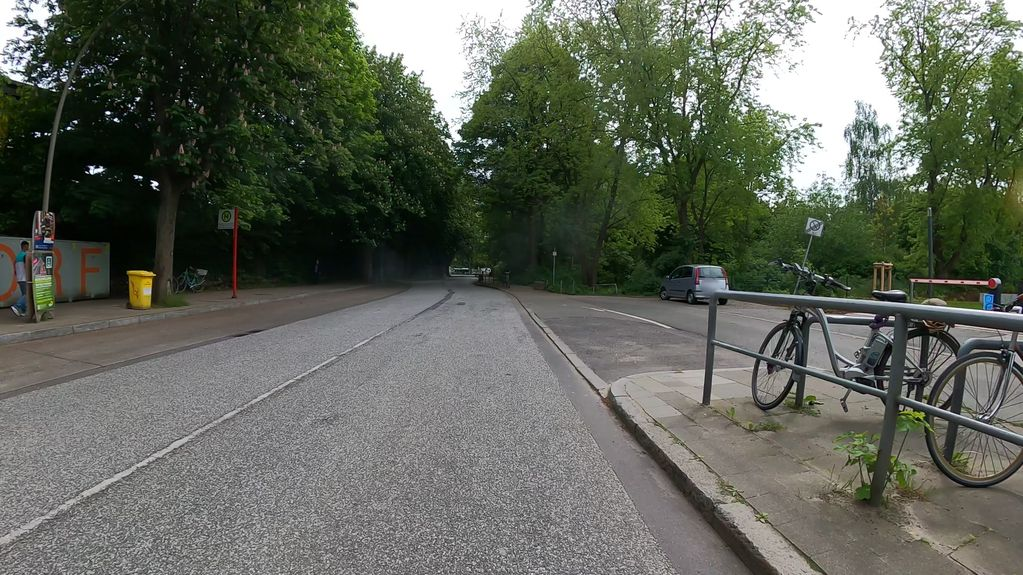

In [3]:
from IPython.display import Image as IPythonImage
IPythonImage(path)

In [4]:
# mapillary_image_id
# data/roads/streetSurfaceVis_v1_0.csv
import pandas as pd

# Load the CSV file
df = pd.read_csv("../data/roads/streetSurfaceVis_v1_0.csv")

# Find the row with matching mapillary_image_id

matching_row = df[df["mapillary_image_id"] == int(image_id)]
matching_row


,mapillary_image_id,user_id,user_name,captured_at,longitude,latitude,train,surface_type,surface_quality
3433,326551592186704,109115837985025,veloroute_hamburg,1622556174514,10.030993,53.621124,True,asphalt,good


In [5]:
import os
import json
from datetime import datetime
import pandas as pd

# NOTE: change this to the path to the images. Not including in repo for size.
image_dir = "/Users/jeremyherzog/Downloads/s_1024"
output_file = "../data/roads/road_image_embeddings.parquet"

# Create empty DataFrame with schema
pd.DataFrame(columns=[
    "mapillary_image_id", 
    "image_embeddings",
    "insert_timestamp",
    "longitude",
    "latitude", 
    "tags"
]).to_parquet(output_file)

batch_size = 10
images = []
batch_rows = []

for index, row in df.iterrows():
    image_path = os.path.join(image_dir, f"{row['mapillary_image_id']}.jpg")
    
    try:
        image = Image.open(image_path)
        images.append(image)
        batch_rows.append(row)
    except FileNotFoundError:
        print(f"Image not found: {image_path}")
        continue
    
    if len(images) == batch_size:
        # Process batch
        batch_embeddings = get_image_embeddings(images, processor, vision_model)
        
        # Create batch DataFrame and append to parquet
        batch_data = []
        for i, row in enumerate(batch_rows):
            batch_data.append({
                "mapillary_image_id": row["mapillary_image_id"],
                "image_embeddings": batch_embeddings[i].tolist(),
                "insert_timestamp": datetime.fromtimestamp(row["captured_at"]/1000).isoformat(),
                "longitude": row["longitude"],
                "latitude": row["latitude"],
                "tags": json.dumps({"smoothness": row["surface_quality"], "surface": row["surface_type"]})
            })
        
        batch_df = pd.DataFrame(batch_data)
        if os.path.exists(output_file):
            existing_df = pd.read_parquet(output_file)
            combined_df = pd.concat([existing_df, batch_df], ignore_index=True)
            combined_df.to_parquet(output_file)
        else:
            batch_df.to_parquet(output_file)
        
        images = []
        batch_rows = []

    if index % batch_size == 0:
        print(f"Processed {index} rows")
        
# Process any remaining images
if images:
    batch_embeddings = get_image_embeddings(images, processor, vision_model)
    batch_data = []
    for i, row in enumerate(batch_rows):
        batch_data.append({
            "mapillary_image_id": row["mapillary_image_id"],
            "image_embeddings": batch_embeddings[i].tolist(),
            "insert_timestamp": datetime.fromtimestamp(row["captured_at"]/1000).isoformat(),
            "longitude": row["longitude"],
            "latitude": row["latitude"],
            "tags": json.dumps({"smoothness": row["surface_quality"], "surface": row["surface_type"]})
        })
    
    batch_df = pd.DataFrame(batch_data)
    if os.path.exists(output_file):
        existing_df = pd.read_parquet(output_file)
        combined_df = pd.concat([existing_df, batch_df], ignore_index=True)
        combined_df.to_parquet(output_file)
    else:
        batch_df.to_parquet(output_file)


Processed 0 rows


/var/folders/f6/s4sj6jdn3r15j_fzl9k0cq2c0000gn/T/ipykernel_5693/1698088376.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([existing_df, batch_df], ignore_index=True)


Processed 10 rows
Processed 20 rows
Processed 30 rows
Processed 40 rows
Processed 50 rows
Processed 60 rows
Processed 70 rows
Processed 80 rows
Processed 90 rows
Processed 100 rows
Processed 110 rows
Processed 120 rows
Processed 130 rows
Processed 140 rows
Processed 150 rows
Processed 160 rows
Processed 170 rows
Processed 180 rows
Processed 190 rows
Processed 200 rows
Processed 210 rows
Processed 220 rows
Processed 230 rows
Processed 240 rows
Processed 250 rows
Processed 260 rows
Processed 270 rows
Processed 280 rows
Processed 290 rows
Processed 300 rows
Processed 310 rows
Processed 320 rows
Processed 330 rows
Processed 340 rows
Processed 350 rows
Processed 360 rows
Processed 370 rows
Processed 380 rows
Processed 390 rows
Processed 400 rows
Processed 410 rows
Processed 420 rows
Processed 430 rows
Processed 440 rows
Processed 450 rows
Processed 460 rows
Processed 470 rows
Processed 480 rows
Processed 490 rows
Processed 500 rows
Processed 510 rows
Processed 520 rows
Processed 530 rows
Pr

In [6]:
df = pd.read_parquet(output_file)

print(f"Total rows in dataset: {len(df)}")
print(df.head())

Total rows in dataset: 9122
   mapillary_image_id                                   image_embeddings  \
0    1000927687276860  [-0.042904745787382126, -0.054529909044504166,...   
1    1001349260556407  [-0.05258774384856224, -0.040632639080286026, ...   
2    1001419624308587  [-0.049702029675245285, -0.003129136050119996,...   
3    1001712924422413  [-0.04204778000712395, -0.04163790121674538, 0...   
4    1001853784055707  [-0.03942526876926422, -0.027606451883912086, ...   

             insert_timestamp  longitude   latitude  \
0  2022-06-20T10:34:37.353000  13.287805  51.502597   
1  2022-07-28T09:44:36.793000  14.426536  52.217757   
2  2023-10-25T11:52:57.500000  13.457938  52.512914   
3         2023-11-04T10:13:59  13.386874  52.564970   
4         2022-05-11T07:34:43  13.389880  52.546260   

                                                tags  
0  {"smoothness": "intermediate", "surface": "con...  
1        {"smoothness": "bad", "surface": "unpaved"}  
2       {"smoothnes

In [12]:
# take a test image and find top 3 closest images
test_image_path = "../data/roads/bad_unpaved_road.jpg"

test_image = Image.open(test_image_path)
print(test_image)
test_image_embedding = get_image_embeddings([test_image], processor, vision_model)[0]

# find top 3 closest images
# Convert embeddings to tensors and get first embedding from test list
test_embedding = torch.tensor(test_image_embedding)
db_embeddings = torch.tensor(df["image_embeddings"])

# Calculate cosine similarity
similarities = torch.nn.functional.cosine_similarity(test_embedding.unsqueeze(0), db_embeddings)
distances = 1 - similarities  # Convert similarity to distance
top_3 = torch.argsort(distances, descending=False)[:3]

# Create a copy of the dataframe with top 3 matches and add similarity scores
result_df = df.iloc[top_3].copy()
result_df['cosine_similarity'] = similarities[top_3].numpy()
result_df

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=720x1280 at 0x16AA67020>


/var/folders/f6/s4sj6jdn3r15j_fzl9k0cq2c0000gn/T/ipykernel_5693/3142184098.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embedding = torch.tensor(test_image_embedding[0])


,mapillary_image_id,image_embeddings,insert_timestamp,longitude,latitude,tags,cosine_similarity
7454,524788185524339,"[-0.062364932149648666, -0.03614688292145729, ...",2021-07-18T08:20:40.415000,13.653365,52.455508,"{""smoothness"": ""very_bad"", ""surface"": ""unpaved""}",0.970036
5328,563911405413775,"[-0.05378693714737892, -0.04710131138563156, 0...",2022-07-20T11:20:06,13.808544,52.266251,"{""smoothness"": ""bad"", ""surface"": ""unpaved""}",0.953641
4226,4590706950946355,"[-0.04639998450875282, -0.044910356402397156, ...",2016-08-21T12:25:08.912000,13.569576,51.157193,"{""smoothness"": ""bad"", ""surface"": ""unpaved""}",0.946827
